In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

## Dades

Emprarem el dataset **Fashion MNIST**, una versió del conegut MNIST creat per l'empresa de venta de roba online _Zalando_. Conté dos conjunts de dades (un d'entrenament i un de test) amb 60000 i 10000 mostres respectivament.

Cada un dels elements del dataset és una imatge de 28x28 pixels i pot ser de 10 categories diferents.

La cárrega i preparació de les dades segueix la mateixa estructura que quan feiem aprenentatge emprant SVM, afegint una passa més, la creació de subconjunts d'entrenament (també coneguts com _mini-batches_).

1. Carrega de dades.
2. Estandarització.
3. Creació de grups d'entrenament.


In [7]:
etiquetes = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Definim una seqüència (composició) de transformacions 
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # mitjana, desviacio tipica (precalculats)
    ])

# Descarregam un dataset ja integrat en la llibreria Pytorch
train = datasets.FashionMNIST('../data', train=True, download=True, transform=transform)
test = datasets.FashionMNIST('../data', train=False, transform=transform)

Es molt important entendre com és l'estructura dels conjunts que necessitam per fer feina amb la xarxa. 

In [8]:
train_batch_size = 64
test_batch_size = 100

# Transformam les dades en l'estructura necessaria per entrenar una xarxa
train_loader = torch.utils.data.DataLoader(train, train_batch_size)
test_loader = torch.utils.data.DataLoader(test, test_batch_size)


A continuació cream un iterador sobre el nostre conjunt d'entrenament, això ens torna un _batch_. Mostram la primera imatge juntament amb la seva etiqueta. Després mostram informació referent al _batch_.

In [53]:
iterador =  iter(train_loader) # Un iterador!!

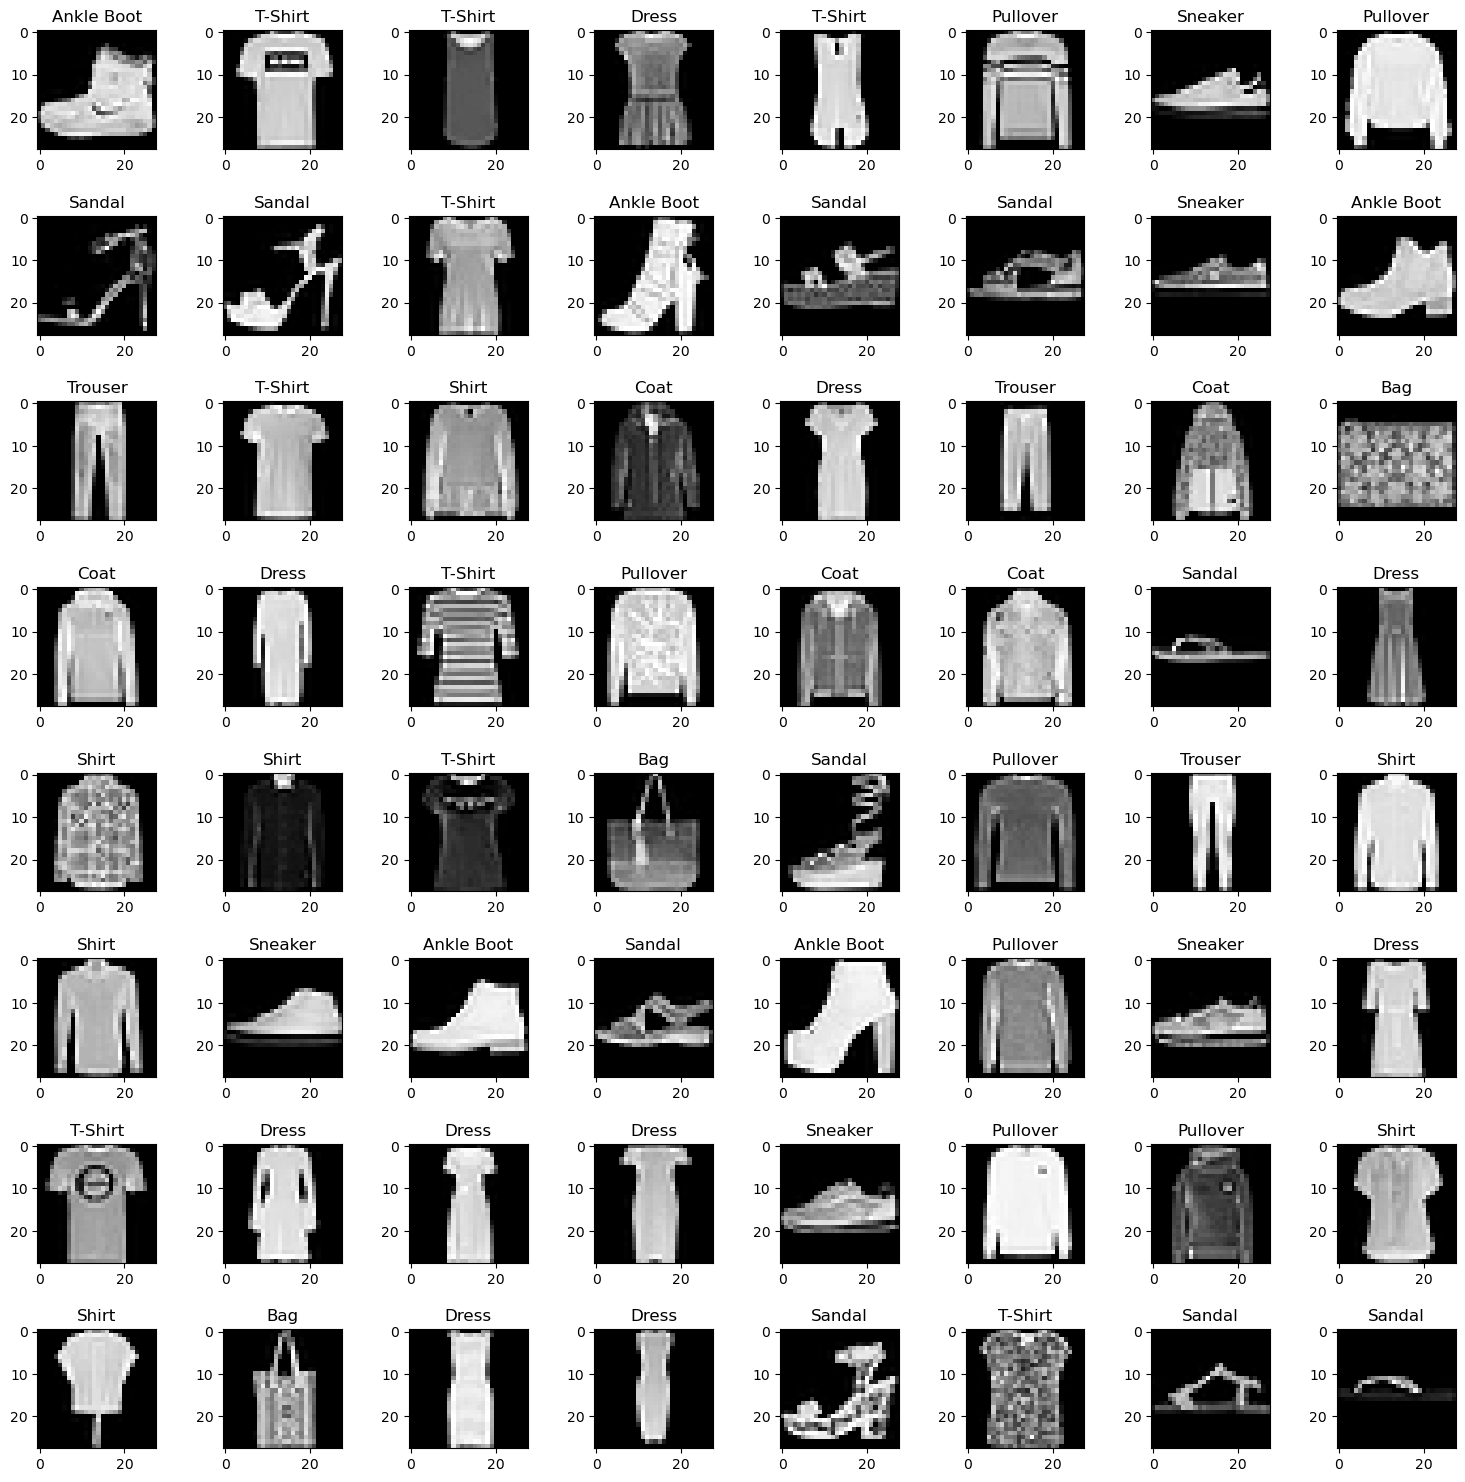

__________________________________________________
Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


In [54]:
features, labels = next(iterador)

# TODO: mostrar una imatge del batch i com a títol posar l'etiqueta.
"""plt.imshow(features[0].permute(1,2,0), cmap="gray")
plt.title(etiquetes[int(labels[0])])
plt.show()"""

# Extra: mostrar una graella amb tot el batch·
rows, cols = 8, 8
fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
fig.tight_layout()
for i in range(rows):
    for j in range(cols):
        x = i*rows+j
        axs[i,j].imshow(features[x].permute(1,2,0), cmap="gray")
        axs[i,j].title.set_text(etiquetes[int(labels[x])])
plt.show()

print("_"*50)
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")



## Definició de la xarxa
Emprant el mòdul `nn` de _Pytorch_ podem definir la nostra pròpia classe. Com a mínim hi definirem dos mètodes:

  - Constructor: mètode `__init__` en el que definim les capes de la nostra xarxa.
  - `forward`: mètode en el que definim com és el fluxe de la informació. Aquí podem afegir capes no entrenables.

La xarxa que heu de crear és una xarxa densa, per tant totes les capes seràn linears: `nn.Linear`. On la darrera capa ha de tenir una dimensionalitat igual al nombre de classes.

Com a sortida és recomanable usar la funció _softmax_ que converteix un vector de $K$ nombres reals en una distribució de probabilitat de $K$ possibles resultats. És una generalització de la funció logística a múltiples dimensions, i s'utilitza en regressió logística multinomial. La funció softmax s'utilitza sovint com l'última funció d'activació d'una xarxa neuronal per normalitzar la sortida d'una xarxa a una distribució de probabilitat sobre classes de sortida predites. Es calcula de la següent manera:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ab3ef6ba51afd36c1d2baf06540022053b2dca73"
     alt="Softmax"
     style="float: left; margin-right: 10px;" />





In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # TODO: definir les capes que necessitem
        self.l1 = nn.Linear(28*28, 14*14)
        self.l2 = nn.Linear(14*14, 7*7)
        self.l3 = nn.Linear(7*7, len(etiquetes))
        self.relu = F.ReLU()

    def forward(self, x):
            
        x = torch.flatten(x,1) # TODO: comprovar l'atribut shape de x un cop fet flatten
        # TODO connectar les capes. El valor de retorn d'una cap és l'entrada de la següent
        x = self.l1(x)
        x = self.relu(x)

        x = self.l2(x)
        x = self.relu(x)

        x = self.l3(x)

        output = F.softmax(x, dim=1)
        return output

## Entrenament

Les bones pràctiques de programació ens diuen que cal organitzar el codi en funcions. En definirem una per la passa d'entrenament i una altra per la fase de test.

En aquesta fase s'ha de definir la funció de pèrdua, recordau que aquesta és la funció que avalua la diferència entre el que ha predit la xarxa i la sortida desitjada. Existeixen múltiples funcions de pèrdua que emprarem segons el problema a resoldre i les seves particularitats. Per exemple en el problema de regressió de la setmana passada vàrem emprar l'error absolut al quadrat (_MSE_).

Nosaltres emprarem: **cross entropy** que prové de la teoria de la informació de _Shannon_ i que vé a explicar que l'entropia d'una variable aleatòria és el nivell mitjà d'informació / sorpresa / incertesa" inherent als possibles resultats d'aquesta variable. La fórmula és la següent:

$ LCE = -∑_{i=1}^M t_i \log(p_i)$

On $M$ és el nombre de classes, $t_i$ és un valor binari indicant si l'observació és d'aquesta classe (valor 1 si ho és i valor 0 en cas contrari) i $p_i$ és el resultat de la funció _Softmax_ per aquesta classe.

In [63]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train() # Posam la xarxa en mode entrenament

    loss_v = 0 # Per calcular la mitjana (és la vostra)

    # Bucle per entrenar cada un dels batch
    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device) 

        optimizer.zero_grad()
        output = model(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        ## Informació de debug
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval() # Posam la xarxa en mode avaluació

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
            correct += pred.eq(target.view_as(pred)).sum().item()
 
    # Informació de debug
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

A continuació definim els paràmetres d'entrenament i el bucle principal:

In [ ]:
torch.manual_seed(33)

# Ens permet emprar l'entorn de cuda. El podem activar a "Entorno de ejecución"
use_cuda = False
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Paràmetres bàsics
epochs =  50#  ¿?
lr =  0.01#  ¿?

model = Net().to(device)

# Stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr=lr) #momentum

# Guardam el valor de pèrdua mig de cada època, per fer el gràfic final
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_loader)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301336, Average: 0.035958
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.297276, Average: 0.035895
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.287128, Average: 0.035736
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.282120, Average: 0.035658
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.242531, Average: 0.035040
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.178586, Average: 0.034040
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.196684, Average: 0.034323
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.120987, Average: 0.033140
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.082247, Average: 0.032535
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.942693, Average: 0.030355

Train set: Average loss: 0.0343


Test set: Average loss: 0.0197, Accuracy: 5611/10000 (56%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.052661, Average: 0.032073
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.964893, Average: 0.030701
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.895906, Average: 0.029624
Train Epoch: 1 [1920

In [ ]:
plt.title("Resultats de l'entrenament")
plt.plot(range(1, (epochs + 1)), train_l,  c="red", label="train")
plt.plot(range(1,  (epochs + 1)), test_l,  c="green", label="test")
plt.legend();

## SVM

La pregunta és: Ho podem fer millor que una SVM lineal?

### Preparació de les dades

Aprofitam el dataset de _Pytorch_ per assegurar que volem resoldre el mateix problema.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

Transformam els tensors en matrius i donam el format adient:

In [ ]:
train_np = train.data.numpy()
test_np = test.data.numpy()

X_train = train_np.reshape((train_np.shape[0], train_np.shape[1]*train_np.shape[2]))
y_train = train.targets.numpy()
X_test = test_np.reshape((test_np.shape[0], test_np.shape[1]*test_np.shape[2]))
y_test = test.targets.numpy()

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

La dimensionalitat és molt gran i no podriem resoldre el problema en un temps raonable, aplicarem un PCA per reduïr les característiques:

In [ ]:
pca = PCA().fit(X_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

pca = PCA(0.95, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

Realitzam l'entrenament:

**Nota**: La cerca de paràmetres no és massa adient....

In [ ]:
parameters = { 'C':[1]}
svc = LinearSVC(max_iter=1500)
clf = GridSearchCV(svc, parameters)
clf.fit(X_train_pca, y_train)
y_predict = clf.predict(X_test_pca)

Per poder fer comparacions directes mostram la mateixa mètrica que amb la xarxa:

In [ ]:
p = accuracy_score(y_predict, y_test)
print(p)